# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
df = pd.read_csv('data/data_no_fliers.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,neo,pha,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,...,class_AST,class_ATE,class_CEN,class_IEO,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,0,0,3.40,2458600.5,58600,20190427.0,0.076009,2.769165,2.558684,10.594067,...,0,0,0,0,0,1,0,0,0,0
1,0,0,4.20,2459000.5,59000,20200531.0,0.229972,2.773841,2.135935,34.832932,...,0,0,0,0,0,1,0,0,0,0
2,0,0,5.33,2459000.5,59000,20200531.0,0.256936,2.668285,1.982706,12.991043,...,0,0,0,0,0,1,0,0,0,0
3,0,0,3.00,2458600.5,58600,20190427.0,0.088721,2.361418,2.151909,7.141771,...,0,0,0,0,0,1,0,0,0,0
4,0,0,6.90,2459000.5,59000,20200531.0,0.190913,2.574037,2.082619,5.367427,...,0,0,0,0,0,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921430 entries, 0 to 921429
Data columns (total 45 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        921430 non-null  int64  
 1   pha        921430 non-null  int64  
 2   H          921430 non-null  float64
 3   epoch      921430 non-null  float64
 4   epoch_mjd  921430 non-null  int64  
 5   epoch_cal  921430 non-null  float64
 6   e          921430 non-null  float64
 7   a          921430 non-null  float64
 8   q          921430 non-null  float64
 9   i          921430 non-null  float64
 10  om         921430 non-null  float64
 11  w          921430 non-null  float64
 12  ma         921430 non-null  float64
 13  ad         921430 non-null  float64
 14  n          921430 non-null  float64
 15  tp         921430 non-null  float64
 16  tp_cal     921430 non-null  float64
 17  per        921430 non-null  float64
 18  per_y      921430 non-null  float64
 19  moid       921430 non-n

### Baseline

In [5]:
X = df.drop(['pha'], axis=1)
y = df['pha']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
tree_pipe = Pipeline([('ss', StandardScaler()),
                     ('clf', DecisionTreeClassifier(random_state=123, class_weight={0:1, 1:200}))])

In [7]:
tree_pipe.fit(X_train, y_train)
y_pred = tree_pipe.predict(X_test)

In [8]:
print('Train Report')
print(classification_report(y_train, tree_pipe.predict(X_train)))
print('\n')
print('Test Report')
print(classification_report(y_test, y_pred))

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    689548
           1       1.00      1.00      1.00      1524

    accuracy                           1.00    691072
   macro avg       1.00      1.00      1.00    691072
weighted avg       1.00      1.00      1.00    691072



Test Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229817
           1       0.97      0.98      0.97       541

    accuracy                           1.00    230358
   macro avg       0.99      0.99      0.99    230358
weighted avg       1.00      1.00      1.00    230358



The testing metrics look promising, but the model is overfit to the training data.

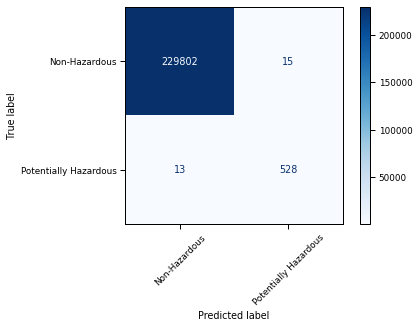

In [58]:
sns.set_context('paper')

plot_confusion_matrix(tree_pipe, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=['Non-Hazardous', 'Potentially Hazardous'], xticks_rotation=45.0);

In [10]:
tree_pipe.steps[1][1].get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 200},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 123,
 'splitter': 'best'}

In [11]:
tree_pipe.steps[1][1].get_depth()

18

The initial tree has a max depth of 18. Will try some lower values in the next iteration in order to address overfitting.

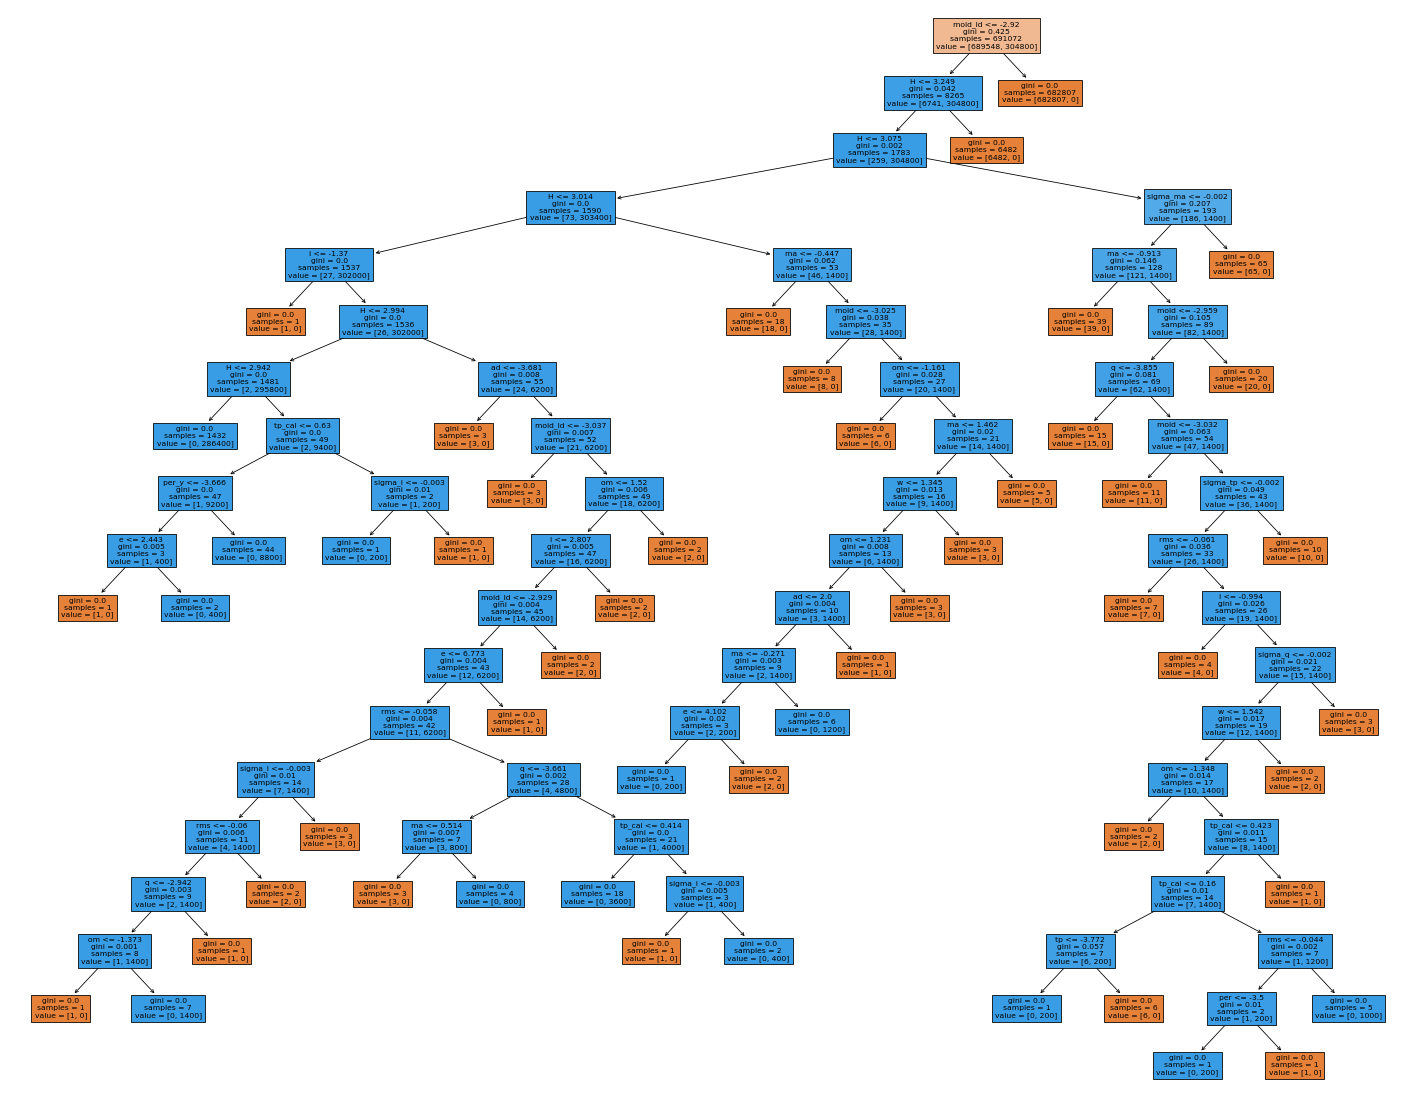

In [59]:
from sklearn.tree import plot_tree

fig= plt.figure(figsize=(25, 20))
_ = plot_tree(tree_pipe.steps[1][1],
             feature_names=X.columns,
             filled=True)

### Iteration 2

This iteration attempts some initial pruning with values < 18 for `max_depth` and some higher values for `min_samples_leaf` and `min_samples_split`.

In [28]:
tree_pipe2 = Pipeline([('ss', StandardScaler()),
                     ('clf', DecisionTreeClassifier(random_state=123))])

param_grid = {
    'clf__class_weight': ['balanced', {0:1, 1:200}],
    'clf__max_depth': [8, 16],
    'clf__min_samples_leaf': [1, 3, 6, 9],
    'clf__min_samples_split': [2, 4, 6, 8]
}

In [29]:
tree_grid2 = GridSearchCV(tree_pipe2, param_grid=param_grid, cv=3, scoring='recall')

In [30]:
tree_grid2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'clf__class_weight': ['balanced', {0: 1, 1: 200}],
                         'clf__max_depth': [8, 16],
                         'clf__min_samples_leaf': [1, 3, 6, 9],
                         'clf__min_samples_split': [2, 4, 6, 8]},
             scoring='recall')

In [31]:
tree_grid2.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=9,
                                        random_state=123))])

In [32]:
y_pred = tree_grid2.predict(X_test)

print('Train Report')
print(classification_report(y_train, tree_grid2.predict(X_train)))
print('\n')
print('Test Report')
print(classification_report(y_test, y_pred))

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    689548
           1       0.95      1.00      0.97      1524

    accuracy                           1.00    691072
   macro avg       0.97      1.00      0.99    691072
weighted avg       1.00      1.00      1.00    691072



Test Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229817
           1       0.94      0.99      0.96       541

    accuracy                           1.00    230358
   macro avg       0.97      1.00      0.98    230358
weighted avg       1.00      1.00      1.00    230358



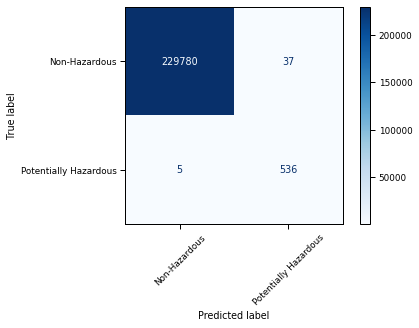

In [60]:
plot_confusion_matrix(tree_grid2, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=['Non-Hazardous', 'Potentially Hazardous'], xticks_rotation=45.0);

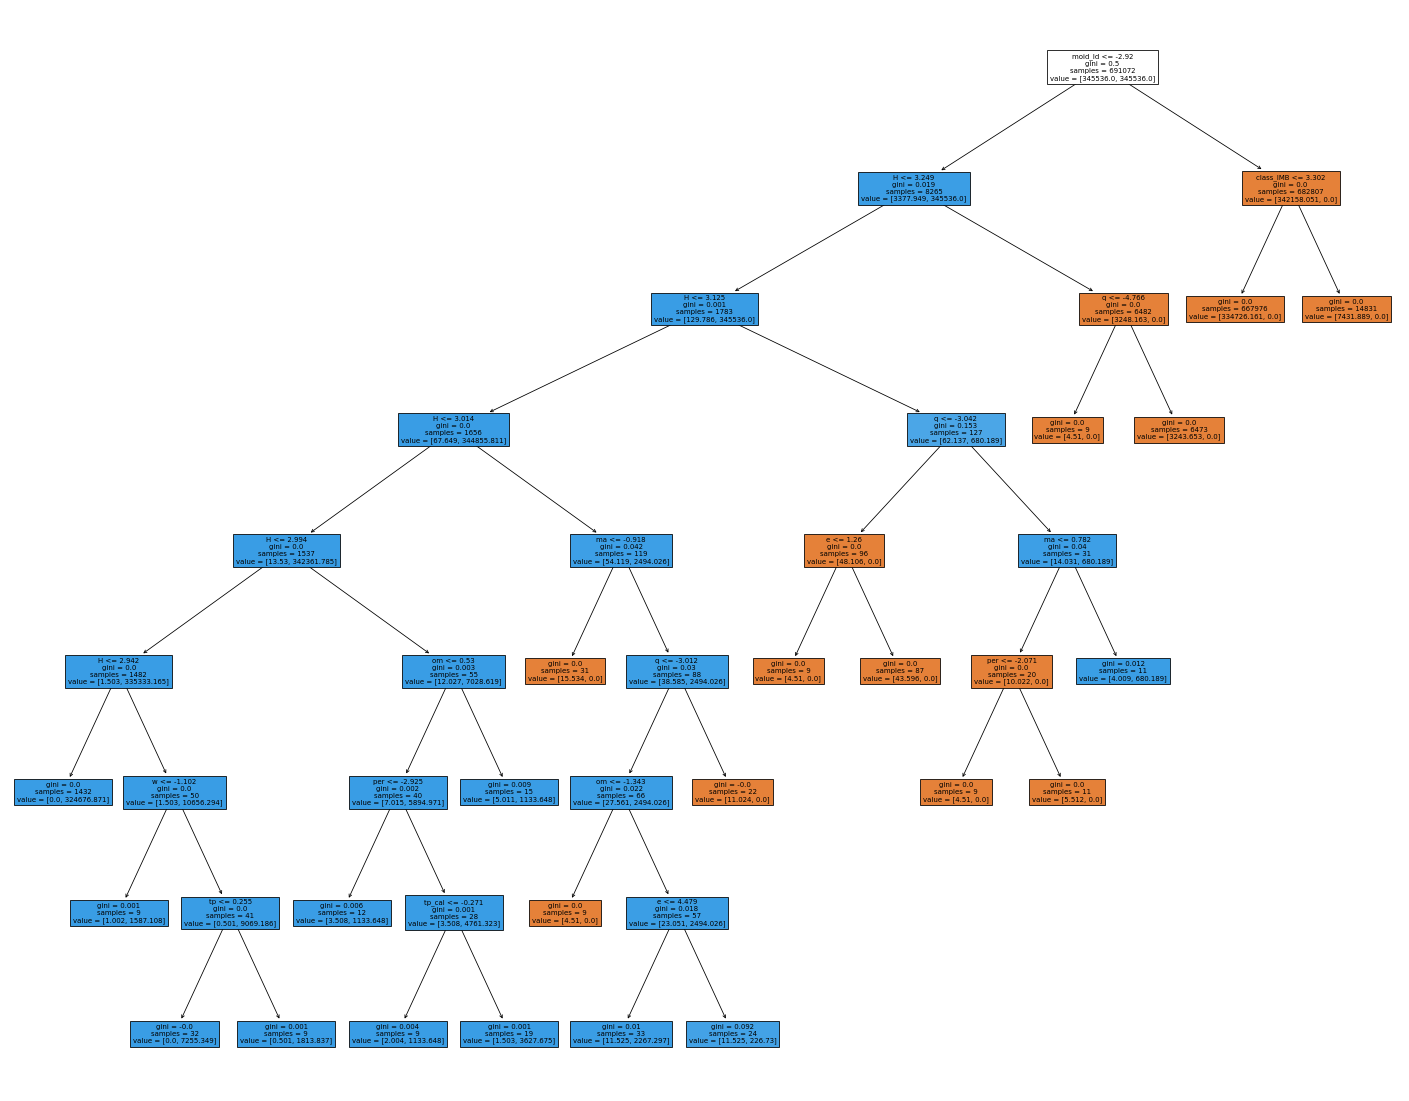

In [61]:
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(tree_grid2.best_estimator_.steps[1][1],
             feature_names=X.columns,
             filled=True)

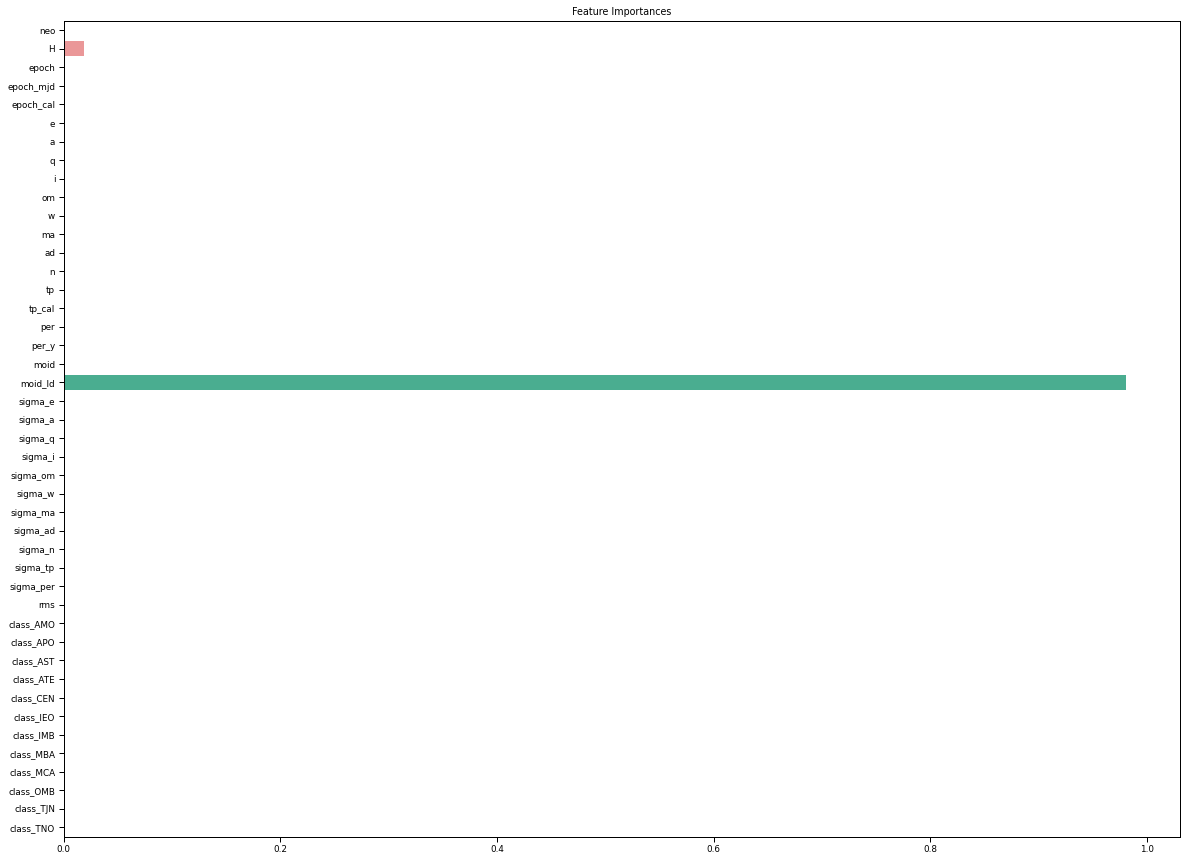

In [62]:
plt.figure(figsize=(20, 15))
sns.barplot(x = tree_grid2.best_estimator_.steps[1][1].feature_importances_, 
            y = X.columns)
plt.title('Feature Importances');

`moid_ld` (closeness of orbit to orbit of Earth) is the most significant feature by far, followed by `H` (visual magnitude). Other features do not seem to have a signal in the feature importances plot, which is concerning.

In [36]:
tree_grid2.best_params_

{'clf__class_weight': 'balanced',
 'clf__max_depth': 8,
 'clf__min_samples_leaf': 9,
 'clf__min_samples_split': 2}

The model chose the lower end of `max_depth`, the higher end of `min_samples_leaf`, and the default `min_samples_split`. 

### Iteration 3

In [37]:
tree_pipe3 = Pipeline([('ss', StandardScaler()),
                     ('clf', DecisionTreeClassifier(random_state=123))])

param_grid = {
    'clf__class_weight': ['balanced', {0:1, 1:200}],
    'clf__max_depth': [4, 6, 8, 12],
    'clf__min_samples_leaf': [7, 8, 9, 10, 11],
    'clf__min_samples_split': [2, 3, 4]
}

In [38]:
tree_grid3 = GridSearchCV(tree_pipe3, param_grid=param_grid, cv=3, scoring='recall')

In [39]:
tree_grid3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'clf__class_weight': ['balanced', {0: 1, 1: 200}],
                         'clf__max_depth': [4, 6, 8, 12],
                         'clf__min_samples_leaf': [7, 8, 9, 10, 11],
                         'clf__min_samples_split': [2, 3, 4]},
             scoring='recall')

In [40]:
y_pred = tree_grid3.predict(X_test)

print('Train Report')
print(classification_report(y_train, tree_grid3.predict(X_train)))
print('\n')
print('Test Report')
print(classification_report(y_test, y_pred))

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    689548
           1       0.90      1.00      0.95      1524

    accuracy                           1.00    691072
   macro avg       0.95      1.00      0.97    691072
weighted avg       1.00      1.00      1.00    691072



Test Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229817
           1       0.90      0.99      0.94       541

    accuracy                           1.00    230358
   macro avg       0.95      1.00      0.97    230358
weighted avg       1.00      1.00      1.00    230358



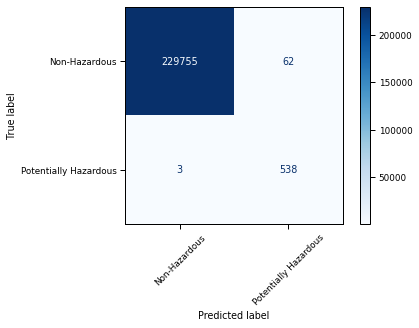

In [63]:
plot_confusion_matrix(tree_grid3, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=['Non-Hazardous', 'Potentially Hazardous'], xticks_rotation=45.0);

We have sacrificed some precision in order to identify more potentially hazardous asteroids correctly.

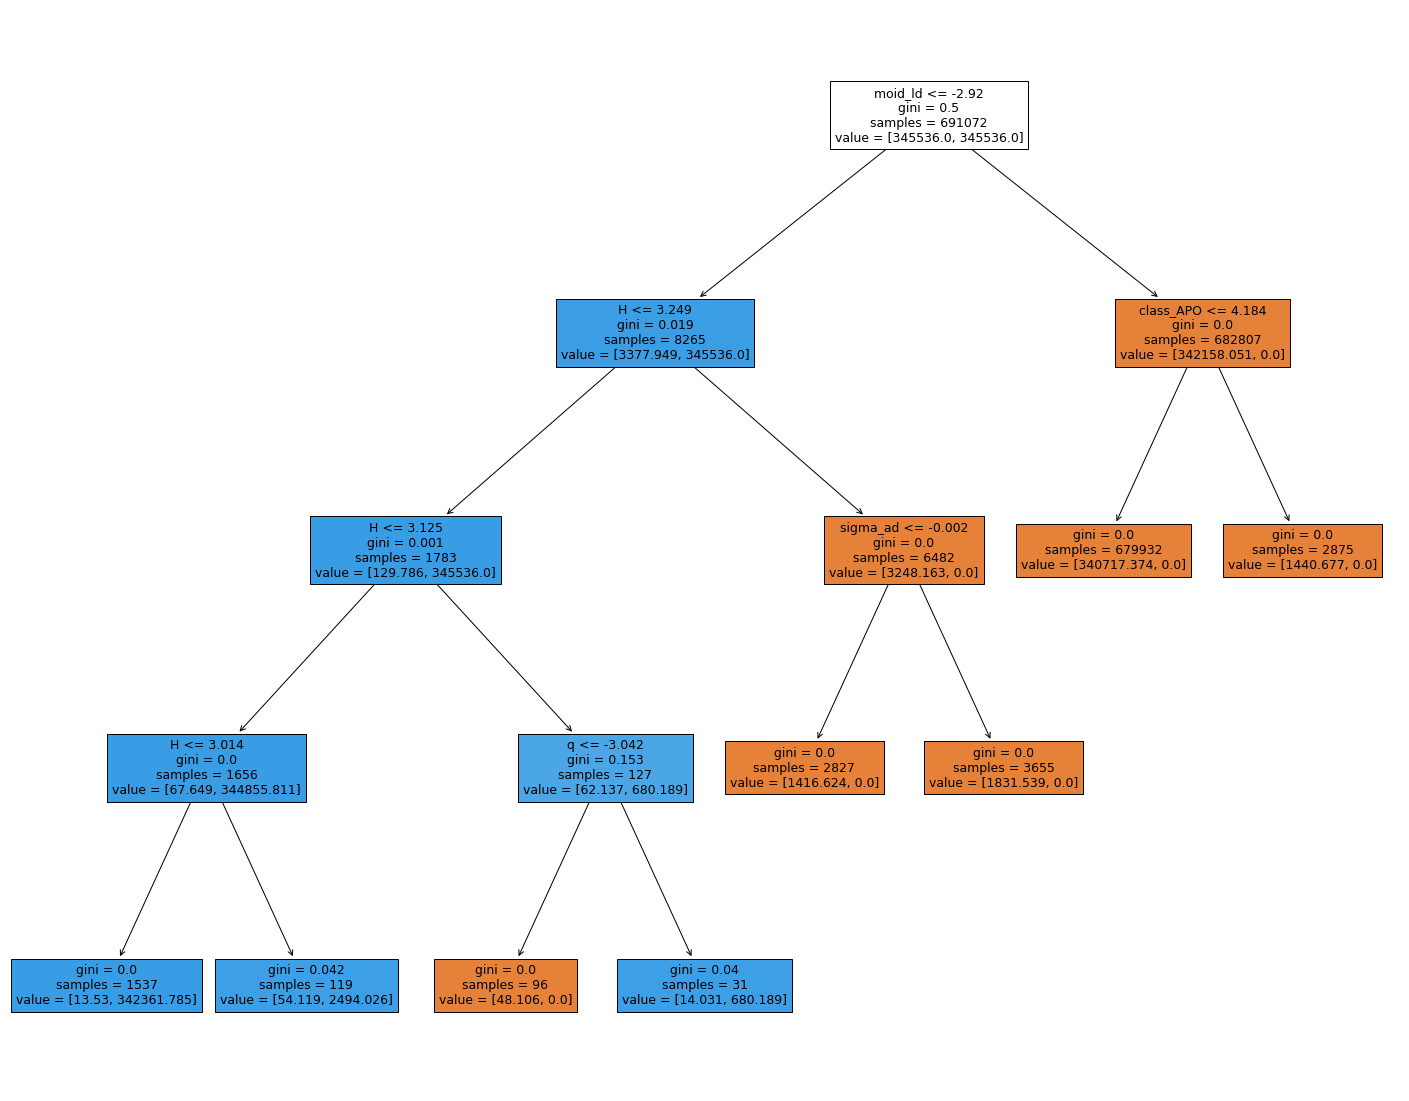

In [42]:
fig = plt.figure(figsize=(25, 20))
_ = plot_tree(tree_grid3.best_estimator_.steps[1][1],
             feature_names=X.columns,
             filled=True)

In [43]:
tree_grid3.best_params_

{'clf__class_weight': 'balanced',
 'clf__max_depth': 4,
 'clf__min_samples_leaf': 7,
 'clf__min_samples_split': 2}

### Iteration 4

In [45]:
tree_pipe4 = Pipeline([('ss', StandardScaler()),
                     ('clf', DecisionTreeClassifier(random_state=123,
                                                   min_samples_split=2))])

param_grid = {
    'clf__class_weight': ['balanced', {0:1, 1:200}],
    'clf__max_depth': [3, 4, 5],
    'clf__min_samples_leaf': [6, 7, 8]
}

tree_grid4 = GridSearchCV(tree_pipe4, param_grid=param_grid, cv=3, scoring='recall')

In [46]:
tree_grid4.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=123))]),
             param_grid={'clf__class_weight': ['balanced', {0: 1, 1: 200}],
                         'clf__max_depth': [3, 4, 5],
                         'clf__min_samples_leaf': [6, 7, 8]},
             scoring='recall')

In [47]:
y_pred = tree_grid4.predict(X_test)

print('Train Report')
print(classification_report(y_train, tree_grid4.predict(X_train)))
print('\n')
print('Test Report')
print(classification_report(y_test, y_pred))

Train Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    689548
           1       0.85      1.00      0.92      1524

    accuracy                           1.00    691072
   macro avg       0.93      1.00      0.96    691072
weighted avg       1.00      1.00      1.00    691072



Test Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    229817
           1       0.85      0.99      0.92       541

    accuracy                           1.00    230358
   macro avg       0.92      1.00      0.96    230358
weighted avg       1.00      1.00      1.00    230358



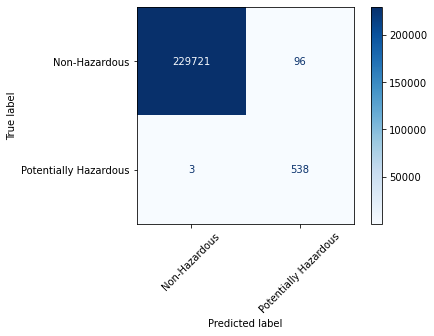

In [48]:
plot_confusion_matrix(tree_grid4, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=['Non-Hazardous', 'Potentially Hazardous'], xticks_rotation=45.0);

Continuing to prioritize recall while gridsearching parameters does not seem to increase recall for the positive class (model has still only missed 3 potentially hazardous asteroids), but now there are more false positives than the previous run (96 as opposed to 62, from the previous iteration).

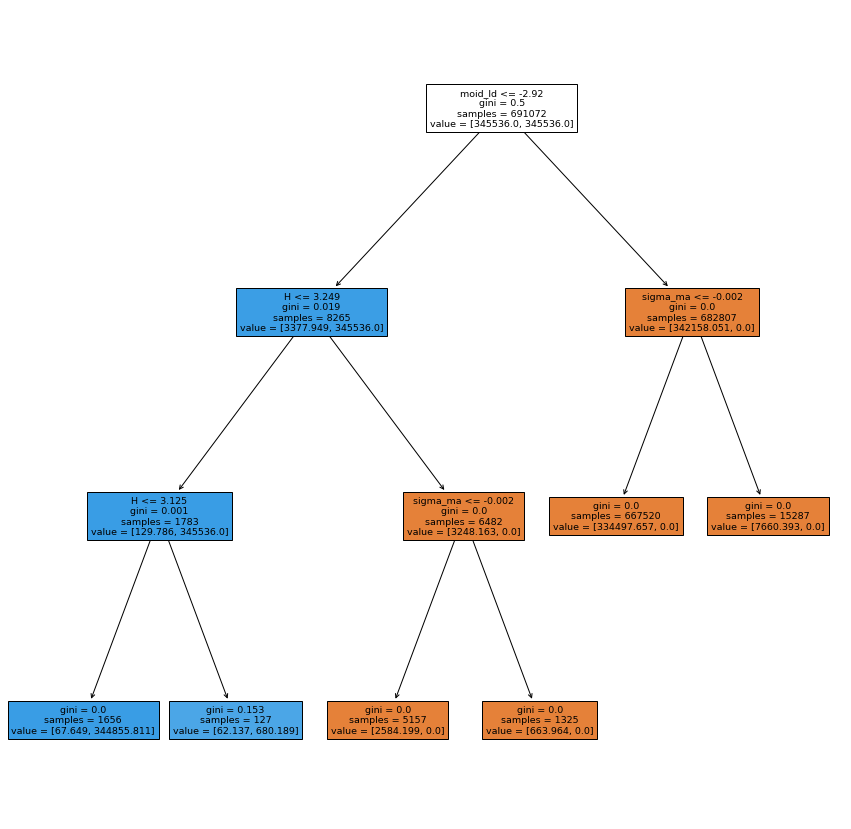

In [49]:
fig= plt.figure(figsize=(15, 15))
_ = plot_tree(tree_grid4.best_estimator_.steps[1][1],
             feature_names=X.columns,
             filled=True)

<AxesSubplot:>

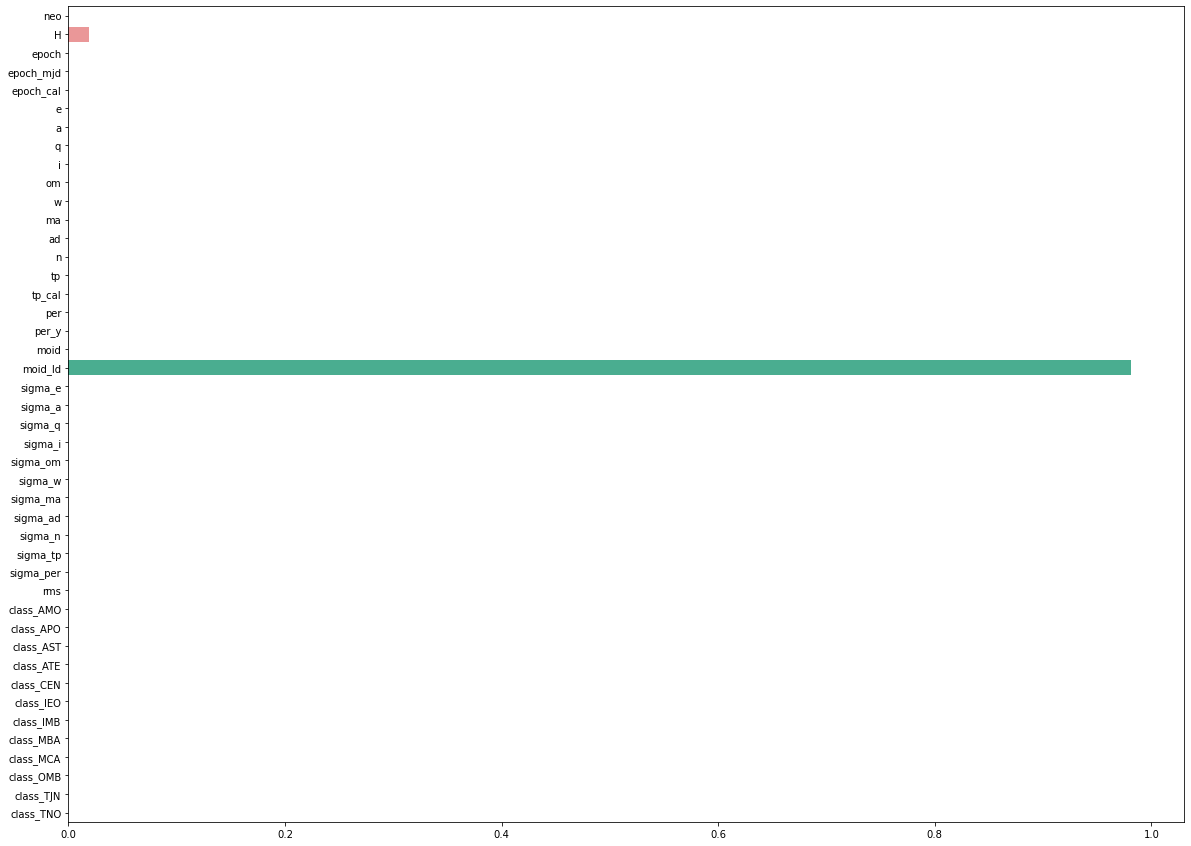

In [50]:
plt.figure(figsize=(20, 15))
sns.barplot(x = tree_grid4.best_estimator_.steps[1][1].feature_importances_, 
            y = X.columns)

In [51]:
tree_grid4.best_params_

{'clf__class_weight': 'balanced',
 'clf__max_depth': 3,
 'clf__min_samples_leaf': 6}